# Logistic Regression Excercise 2

## Multi-class classification of MNIST using Logistic Regression

The multi-class scenario for logistic regression is quite similar to the binary case, except that the label $y$ is now an integer in {1, ...., K} where $K$ is the number of classes. In this excercise you will be provided with handwritten digit images. Write the code and compute the test accuracy by training a logistic regression based classifier in (i) one-vs-one, and (ii) one-vs-all setting.

In [1]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        #print('searching: %s'%nb_path)
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        #print('searching: %s' % nb_path)
        if os.path.isfile(nb_path):
            return nb_path

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        #print('Found %d cells'%len(nb.cells))
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]


#  register the NotebookFinder with sys.meta_path
print('running importer')
sys.meta_path.append(NotebookFinder())

running importer


In [2]:
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set();
import pandas as pd
from utils import plot_decision_boundary, get_accuracy, get_prediction
from utils import plot_2D_input_datapoints, generate_gifs, sigmoid, normalize
import math
import gif
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from utils.ipynb


In [3]:
# Let's initialize our weights using uniform distribution
def weight_init_uniform_dist(X, y):
  
    np.random.seed(312)
    n_samples, n_features = np.shape(X)
    _, n_outputs = np.shape(y)

    limit = 1 / math.sqrt(n_features)
    weights = np.random.uniform(-limit, limit, (n_features, n_outputs))
    weights[-1] = 0

    return weights

In [4]:
np.random.seed(12)

# One hot encoding of our output label vector y
def one_hot(a):
    b = np.zeros((a.size, a.max()+1))
    b[np.arange(a.size), a] = 1
    return b

# Loading dataset
digits = datasets.load_digits()

# One-hot encoding of target label, Y
Y = digits.target
Y = one_hot(Y)

# Absorbing weight b of the hyperplane
X = digits.data
b_ones = np.ones((len(X), 1))
X = np.hstack((X, b_ones))

<Figure size 432x288 with 0 Axes>

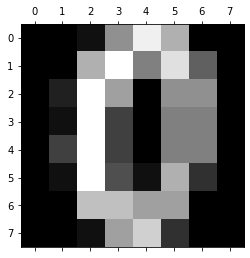

In [5]:
sns.reset_orig()

plt.gray()
plt.matshow(digits.images[10])
plt.show();

In [6]:
# Splitting dataset into train, val, and test set.
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, shuffle=True, test_size = 0.167)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = 0.12517)

print("Training dataset: ", X_train.shape)
print("Validation dataset: ", X_val.shape)
print("Test dataset: ", X_test.shape)

Training dataset:  (1308, 65)
Validation dataset:  (188, 65)
Test dataset:  (301, 65)


In [7]:
# Normalizing X_train and absorbing weight b of the hyperplane
X_normalized_train = normalize(X_train[:, :64])

b_ones = np.ones((len(X_normalized_train), 1))
X_normalized_train = np.hstack((X_normalized_train, b_ones))

In [8]:
X_normalized_train.shape

(1308, 65)

### Write your code below

## Implementing One vs. One Classification

In [9]:
def sign(x):
    return 2*(x>=0)-1

set_lim = 1000
set_tries = 50

def one_vs_one_classifer(X, Y, lr=(1.0/10), n_epochs=set_lim, debug=False):
    z = X.shape
    n = z[0]
    d = z[1]
    sz = (d,1)
    W = np.random.uniform(0,1,size=sz)
    acc = -1
    for epoch in range(n_epochs):
        y_pred = sign(np.matmul(X,W))
        incorrect = y_pred!=Y
        sm = incorrect.sum()
        acc = sm/n
        incorrect = incorrect * Y
        W = W + lr * np.matmul(np.transpose(X),incorrect)
        pr_ep = (n_epochs//5)
        if  debug and epoch%pr_ep == 0:
            pr_ac = round(100*acc,2)
            print("Epoch : ", epoch, "The Incorrect Percentage : ", pr_ac)
    return W, acc

def all_1v1_classifiers(X, Y, lr=1/10.0, n_epochs=set_lim):
    z = X.shape
    n = z[0]
    d = z[1]
    k = Y.shape[-1]
    dim = (k, k, d, 1)
    Ws = np.zeros(dim)
    ACCs = np.ones((k, k))
    ACCs *= -1
    for i in range(k):
        j = i+1
        while j<k:
            Z = Y[:,i]
            ci = (Z==1)
            ZZ = Y[:,j]
            cj = (ZZ==1)
            ex = [X[ci], X[cj]]
            ex = np.vstack(ex)
            ex = np.vstack([X[ci], X[cj]])
            precalc_i = np.ones((ci.sum(),1))
            precalc_j = np.ones((cj.sum(),1))
            ey = [-1*precalc_i, precalc_j]
            ey = np.vstack(ey)
            ANS = one_vs_one_classifer(ex, ey, lr, n_epochs)
            Ws[i,j] = ANS[0]
            ACCs[i,j] = ANS[1]
            j+=1
    return Ws, ACCs

In [10]:
def get_1v1_tree(tree, label):
    sm = sum(label)
    if sm==1:
        return [None,label]
    i = tree[0][0]
    j = tree[0][1]
    treei = []
    treej = []
    for node in tree:
        if j not in node:
            treei.append(node)
        if i not in node:
            treej.append(node)
    
    labeli = label.copy()
    labelj = label.copy()
    labeli[j] = 0
    labelj[i] = 0
    p1 = get_1v1_tree(treei, labeli)
    p2 = get_1v1_tree(treej, labelj)
    return [ [i,j], [p1, p2] ]

def classify_1v1_single(x, Ws, tree):
    node = tree[0]
    label = tree[1]
    if node != None:
        i = node[0]
        j = node[1]
        calc = x@Ws[i,j][:,0]
        res = (sign(calc) + 1)//2
        return classify_1v1_single(x, Ws, label[res])
    return label

def classify_1v1(X, Ws, tree):
    n = X.shape[0]
    k = 10
    dim = (n,k)
    y_preds = np.zeros(dim)
    for i in range(len(X)):
        x = X[i]
        y_preds[i] = classify_1v1_single(x, Ws, tree)
    return y_preds

def get_acc(y_pred, y):
    p1 = np.argmax(y_pred, axis=1)
    p2 = np.argmax(y, axis=1)
    P = np.count_nonzero(p1 == p2)
    return  P/y.shape[0]


## Training classifiers

In [11]:
store = all_1v1_classifiers(X_train, Y_train)
Ws = store[0]
k = Y_train.shape[1]
ACCs = store[1]
temp = np.unravel_index(np.argsort(ACCs, axis=None), ACCs.shape)
temp = np.transpose(temp)
cnt = (k*(k-1))//2
tree_order_desc = np.vstack(temp[::-1][:cnt])


## Choosing Classification Tree using Validation

In [12]:
from copy import deepcopy

np.random.seed(1)
tries = set_tries
O = np.ones((k))
best_tree = None
max_val_acc = -10
for _ in range(tries):
    tree_order = tree_order_desc.copy()
    np.random.shuffle(tree_order)
    tree = get_1v1_tree(tree_order, O)
    val_acc = classify_1v1(X_val, Ws, tree)
    val_acc = get_acc(val_acc, Y_val)
    if val_acc <= max_val_acc:
        pass
    else:
        max_val_acc = val_acc
        best_tree = deepcopy(tree)

tree = deepcopy(best_tree)
val = 100*max_val_acc
print("Best val_acc:", round(val, 3))

Best val_acc: 96.277


## One vs. One Results

In [13]:
train_acc_1v1 = classify_1v1(X_train, Ws, tree)
train_acc_1v1 = get_acc(train_acc_1v1, Y_train)

val_acc_1v1 = classify_1v1(X_val, Ws, tree)
val_acc_1v1 = get_acc(val_acc_1v1, Y_val)

test_acc_1v1 = classify_1v1(X_test, Ws, tree)
test_acc_1v1 = get_acc(test_acc_1v1, Y_test)

print("One vs. One classification:")
val = 100*train_acc_1v1
print("Training accuracy:", "%.3f percent" % (val))
val = 100*val_acc_1v1
print("Validation accuracy:", "%.3f percent" % (val))
val = 100*test_acc_1v1
print("Testing accuracy:", "%.3f percent" % (val))

One vs. One classification:
Training accuracy: 100.000 percent
Validation accuracy: 96.277 percent
Testing accuracy: 95.017 percent


## Implementing One vs. All Classification

In [14]:
def one_vs_all_classifier(x,y,lr=1/10.0,max_iters=set_lim,debug=False):
    sh = x.shape
    n = sh[0]
    d = sh[1]
    c = y.shape[1]
    dim = (c,d)
    W = np.random.uniform(-1,1,dim)
    for i in range(max_iters):
        sign_compute = sign(x@W.T)
        incorrect_preds = (sign_compute != y)
        W += lr*np.transpose(np.matmul(np.transpose(x),y*incorrect_preds))
        sm = incorrect_preds.sum()
        if sm != 0:
            pass
        else:
            break
        predef = (max_iters//5)
        if debug and i%predef == 0:
            val = 100*incorrect_preds.sum()/incorrect_preds.size
            print("Epoch:", i+1, "\tIncorrect Predictions:", "%.3f percent" % (val))
    return W

def classify_1v_all(x, w):
    ANS = x@w.T
    return one_hot(np.argmax(ANS, axis=1))

## Training

In [15]:
np.random.seed(1)
Y_train_modified = Y_train.copy()
pre = -1
Y_train_modified[Y_train==0] = pre
set_lim = 1000
W = one_vs_all_classifier(X_train, Y_train_modified)

## One vs. All Results

In [16]:
train_acc_1v_all = classify_1v_all(X_train, W)
train_acc_1v_all = get_acc(train_acc_1v_all, Y_train)

val_acc_1v_all = classify_1v_all(X_val, W)
val_acc_1v_all = get_acc(val_acc_1v_all, Y_val)

test_acc_1v_all = classify_1v_all(X_test, W)
test_acc_1v_all = get_acc(test_acc_1v_all, Y_test)

print("One vs. One classification:")
val = 100*train_acc_1v_all
print("Training accuracy:", "%.3f percent" % (val))
val = 100*val_acc_1v_all
print("Validation accuracy:", "%.3f percent" % (val))
val = 100*test_acc_1v_all
print("Testing accuracy:", "%.3f percent" % (val))

One vs. One classification:
Training accuracy: 97.630 percent
Validation accuracy: 95.745 percent
Testing accuracy: 94.352 percent
